In [1]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
Learn to classify Morse code sequences using a recurrent neural network

Adapted by: 
    Mauri Niininen (AG1LE) for Morse code learning

From:
Dynamic Recurrent Neural Network by Aymeric Damien
TensorFlow implementation of a Recurrent Neural Network (LSTM) that performs dynamic computation over sequences with variable length.
See: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dynamic_rnn.ipynb
'''
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import random
from numpy.random import normal
from morse import Morse

NOISE = False

In [2]:
# ==========
#   MODEL
# ==========


# MODEL Parameters
learning_rate = 0.01
training_steps = 5000
batch_size = 512
display_step = 100
n_samples = 10000 

# NETWORK  Parameters
seq_max_len = 32 # Sequence max length
n_hidden = 64    # Hidden layer num of features  
n_classes = 60   # Each morse character is a separate class

# Create a training set from 'strings.txt' file 
trainset = Morse(n_samples, max_seq_len=seq_max_len,filename='strings.txt')
n_classes = trainset.number_of_classes() # each morse character is a class


if (NOISE):  # Add gaussian noise to training data
    trainset.data = trainset.data +  normal(0.,0.2, seq_max_len*n_samples)\
                    .reshape(n_samples,seq_max_len,1)

# Create a testing set from 'arrl2.txt' file 
testset = Morse(n_samples, max_seq_len=seq_max_len,filename='arrl2.txt')

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, 1])
y = tf.placeholder("float", [None, n_classes])

# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [3]:
def dynamicRNN(x, seqlen, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, seq_max_len, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic
    # calculation.
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32,
                                sequence_length=seqlen)

    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e., if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.stack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [4]:
pred = dynamicRNN(x, seqlen, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()


/Users/mauri/Projects/LSTM_morse/venv/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
# ==================
#   TRAINING SESSION
# ==================
import time


test_data = testset.data
test_label = testset.labels
test_seqlen = testset.seqlen
t_acc = []
t_loss = []

# Add ops to save and restore all the variables.
saver = tf.train.Saver()


# Launch the training session
print ("Launching training session")
start = time.time()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
        
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,seqlen: batch_seqlen})
        if step % display_step == 0 or step == 1:
            # Calculate batch accuracy & loss
            acc, loss = sess.run([accuracy, cost], feed_dict={x: batch_x, y: batch_y,
                                                seqlen: batch_seqlen})
            t_acc.append(acc)
            t_loss.append(loss)
            
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc) + ", Time=" +\
                  "{:.1f} secs".format(time.time()-start))

    print("Optimization Finished!")
    stop = time.time()
    print ("Training duration:","{:.1f} secs".format(stop-start))
    
    # Calculate accuracy
    ac = sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})    
    print("Testing Accuracy:", ac)
        

    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/morse_model.ckpt")
    print("Model saved in file: %s" % save_path)



Launching training session
Step 1, Minibatch Loss= 4.544979, Training Accuracy= 0.00781, Time=3.8 secs
Step 100, Minibatch Loss= 3.860989, Training Accuracy= 0.04412, Time=12.5 secs
Step 200, Minibatch Loss= 3.643906, Training Accuracy= 0.09191, Time=21.4 secs
Step 300, Minibatch Loss= 3.496075, Training Accuracy= 0.09191, Time=30.3 secs
Step 400, Minibatch Loss= 3.386018, Training Accuracy= 0.11029, Time=39.5 secs
Step 500, Minibatch Loss= 3.290379, Training Accuracy= 0.11029, Time=48.6 secs
Step 600, Minibatch Loss= 3.194228, Training Accuracy= 0.11029, Time=57.9 secs
Step 700, Minibatch Loss= 3.087100, Training Accuracy= 0.20588, Time=67.1 secs
Step 800, Minibatch Loss= 2.958046, Training Accuracy= 0.17279, Time=76.5 secs
Step 900, Minibatch Loss= 2.804741, Training Accuracy= 0.21324, Time=85.7 secs
Step 1000, Minibatch Loss= 2.647581, Training Accuracy= 0.25368, Time=94.8 secs
Step 1100, Minibatch Loss= 2.498123, Training Accuracy= 0.22794, Time=105.5 secs
Step 1200, Minibatch Loss

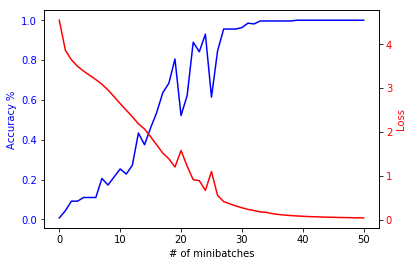

In [6]:
# ===========================
#   PLOT ACCURACY/LOSS CURVES
# ===========================


plt.figure(figsize=(12,6))
fig, ax1 = plt.subplots()
ax1.plot(t_acc, 'b')
ax1.set_xlabel('# of minibatches')
ax1.set_ylabel('Accuracy %', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(t_loss, 'r')
ax2.set_ylabel('Loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

In [7]:
# ================================================================
#   Use saved model to predict characters from Morse sequence data
# ================================================================
# 
NOISE = False

saver = tf.train.Saver()

testset = Morse(n_samples=10000, max_seq_len=seq_max_len,filename='arrl2.txt')
test_data = testset.data
if (NOISE): 
    test_data = test_data +  normal(0.,0.1, 32*10000).reshape(10000,32,1)
test_label = testset.labels
test_seqlen = testset.seqlen
 
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "/tmp/morse_model.ckpt")
    print("Model restored.")
    y_hat = tf.argmax(pred,1)
    ch = sess.run(y_hat, feed_dict={x: test_data, y: test_label,seqlen: test_seqlen})
    s = ''
    for c in ch:
        s += testset.decode(c)
    print( s)

INFO:tensorflow:Restoring parameters from /tmp/morse_model.ckpt
Model restored.
NOW 20 WPM TEXT IS FROM JANUARY 2015 QST  PAGE 56 SITUATIONS WHERE I COULD HAVE BROUGHT A DIRECTIONAL ANTENNA WITH ME, SUCHAS A SMALL YAGI FOR HF OR VHF.  IF ITS LIGHT ENOUGH, ROTATING A YAGI CAN BEDONE WITH THE ARMSTRONG METHOD, BUT IT IS OFTEN VERY INCONVENIENT TO DO SO.PERHAPS YOU DONT WANT TO LEAVE THE RIG BEHIND WHILE YOU GO OUTSIDE TOADJUST THE ANTENNA TOWARD THAT WEAK STATION, OR PERHAPS YOURE IN A TENT ANDITS DARK OUT THERE.  A BATTERY POWERED ROTATOR PORTABLE ROTATION HASDEVELOPED A SOLUTION TO THESE PROBLEMS.  THE 12PR1A IS AN ANTENNA ROTATORFIGURE 6 THAT FUNCTIONS ON 9 TO 14 V DC.  AT 12 V, THE UNIT IS SPECIFIED TODRAW 40 MA IDLE CURRENT AND 200 MA OR LESS WHILE THE ANTENNA IS TURNING.IT CAN BE POWERED FROM THE BATTERY USED TO RUN A TYPICAL PORTABLE STATION.WHILE THE CONTROL HEAD FIGURE 7 WILL FUNCTION WITH AS LITTLE AS 6 V, AEND OF 20 WPM TEXT QST DE AG1LE  NOW 20 WPM     TEXT IS FROM JANUARY 20

NOW 20 WPM TEXT IS FROM JANUARY 2015 QST  PAGE 56 


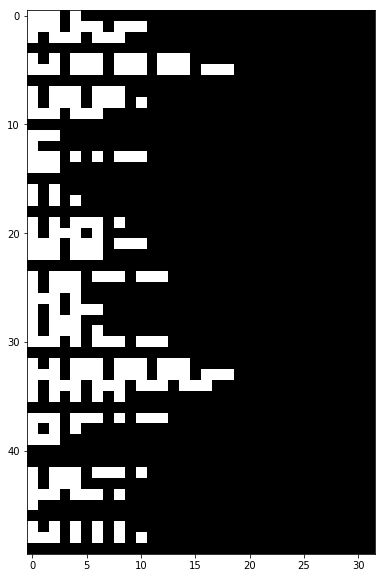

In [8]:

# plot 50 first Morse code lines (32 pix each ) and print 50 first labels
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import numpy as np
from numpy.random import normal

xs = np.array(test_data)
#xs = np.array(trainset.data)

im = xs[:50].reshape(50,32)
#im += normal(0,.1,1600).reshape(50,32)
plt.figure(figsize=(20,10))
plt.imshow(im,cmap = cm.Greys_r)
print (s[:50])

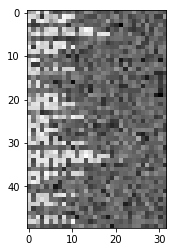

In [9]:
test_data = testset.data
test_data = test_data +  normal(0.,0.2, 32*10000).reshape(10000,32,1)
xs = np.array(test_data)
im = xs[:50].reshape(50,32)
plt.imshow(im,cmap = cm.Greys_r)